# 第 5 章 模型比较

<style>p{text-indent:2em;2}</style>

模型应该被设计成帮助我们理解特定问题或某类相关问题的近似值，而不是真实世界的翻版，从这个意义上讲所有模型都是错误的。即使在有先验的情况下，模型也都是错误的，但每个模型的错误可能有所不同，而其中一些模型比其他模型更好地描述了给定问题。此前的章节将注意力集中在推断问题上，即如何从数据中学习参数的分布。本章将重点讨论一个互补问题：如何比较用于解释相同数据的多个模型。这是数据分析需解决的关键问题之一。

本章将讨论以下内容：

- 后验预测性检查
- 奥卡姆剃刀---简单性和准确性
- 过拟合和欠拟合
- 信息准则
- 贝叶斯因子
- 正则化先验

---


## 5.1 后验预测性检查

`第一章 概率思维`介绍了后验预测性检查的概念，本章将用它来评估拟合出的模型对相同数据的解释程度。如前所述，所有的模型都是错误的，因此后验预测性检查的目的并非判定某个模型是否错误，而是希望通过后验预测性检查更好地把握模型的局限性，以做出适当改进。模型不会再现所有问题，但这并不是问题，因为构建模型都有特定目的，后验预测性检查则是在该目的背景下评估模型的一种方式；因此当考虑了多个模型时，可使用后验预测性检查来对它们进行比较。

让我们读取并绘制一个简单的数据集：

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

Text(0, 0.5, 'y')

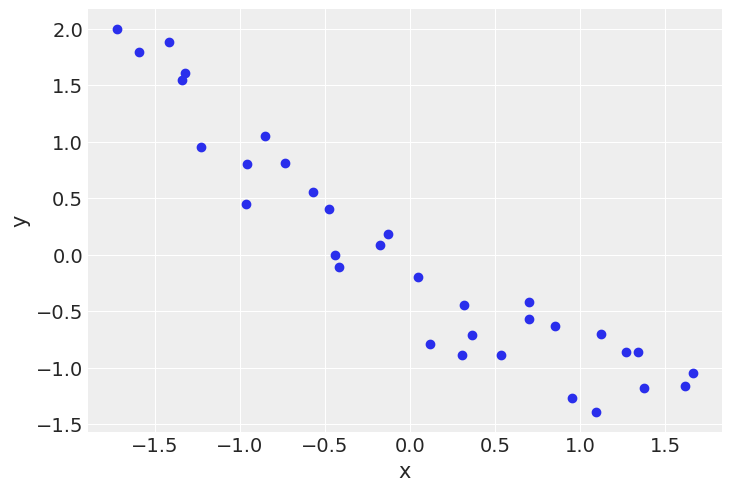

In [2]:
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]
order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210510111807b3.webp)

图 5.1 
</center>

现在，用两个略有不同的模型来拟合数据，第一个是线性模型，第二个是二阶多项式模型：

In [3]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + β * x_1s[0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    
    trace_l = pm.sample(2000)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    
    trace_p = pm.sample(2000)

/tmp/ipykernel_2726/3228340448.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_l = pm.sample(2000)
Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [ϵ, β, α]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.


Only one chain was sampled, this makes it impossible to run some convergence checks


现在绘制这两个模型的平均拟合曲线：

In [ ]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)
α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *x_new
plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)
plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p)
plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210510112129a4.webp)

图 5.2 
</center>

图中二阶模型似乎做得更好，但线性模型也并没有那么糟糕。此时可以使用 PyMC3 来获得两个模型的后验预测样本，并执行检查：

In [ ]:
y_l = pm.sample_posterior_predictive(trace_l, 2000, model=model_l)['y_pred']
y_p = pm.sample_posterior_predictive(trace_p, 2000, model=model_p)['y_pred']

正如已经看到的，后验预测性检查通常使用可视化方式来执行，如下例所示：

In [ ]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
    plt.ylim([-i-0.5, 0.5])
    plt.yticks([])

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_20210510112319ed.webp)

图 5.3
</center>

图 5.3 显示了数据、线性模型和二次多项式模型的均值和四分位数范围。该图对各模型的后验预测样本做了平均，而且两个模型的均值都复现得很好，分位数范围也不是很差。不过在实际问题中，一些小差异可能是值得注意的。可以尝试做更多不同曲线图来探索后验预测性分布。例如，绘制均值和四分位数间相对于数据真实值的离散度。下图就是一个例子：

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
    T_sim = func(d_sim, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, plot_kwargs={'color': c},
    label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/bayesian_stat_2021051011245094.webp)

图 5.4
</center>

图 5.4 中黑色虚线表示根据真实数据计算的平均值和四分位数（因来自真实数据，为确切值而非分布）。图中曲线（与图 5.3 相同颜色代码）表示根据后验预测样本计算得出的均值分布（左图）或四分位数范围分布（右图）。图 5.4 还包括 `p-value` 值，该值来自于预测数据与实际数据的比较和计算。对于两个预测数据集合，我们计算了其平均值和四分位数范围，然后计算了两个统计量等于或大于根据实际数据统计量的比例。**一般而言，如果真实数据和预测结果一致，预期 `p-value` 值在 0.5 左右，否则将处于有偏的后验预测性分布**。

```{tip}
贝叶斯 p 值只是一种衡量后验预测性检查拟合度的数字方法。
```

贝叶斯 `p-value` 与频率派的 `p-value` 名字相似，定义基本上也相同：

```{math}
\text{Bayesian p-value}\triangleq p\left(T_{s i m} \geq T_{o b s} \mid y \right) \tag{式5.1}  \label{式5.1}
```

可以解释为：从模拟数据中获得与观测数据相同或更高统计量值的概率。$T$ 几乎可以是数据的任意统计量。在图 5.4 中，统计量是左侧的平均值和右侧的四分位数范围。通常 $T$ 应该在最初定义推断任务时就选择好。

这些 `p-value` 是贝叶斯的，因为其采样自后验预测性分布。需要注意的是：贝叶斯的 `p-value` 不需要频率主义的任何零假设作为条件；事实上，我们拥有基于观测数据的整个后验分布。此外，贝叶斯也没有使用类似置信度的任何预定义阈值来声明统计显著性，当然也没有执行假设检验。这里只是试图计算一个数字来评估后验预测性分布与数据集的拟合度。

无论使用曲线图还是数据摘要（如贝叶斯 `p-value` ），或是两者组合，后验预测性检查都是非常灵活的。该概念可让分析师思考不同方法来探索后验预测性分布，并使用合适的方法来讲述一个数据驱动的故事，包括但不限于模型比较。

在接下来几节中，我们探索一些其他模型比较的方法。


## 5.2 奥卡姆剃刀 --- 简约性与准确性

假如对同一个问题（或数据）有两个模型，二者对数据解释得同样好，应该选哪个模型呢？有一个基本准则叫做**奥卡姆剃刀**，如果对同一现象有两种不同假说，应选用比较简单的那一种。关于奥卡姆剃刀的论证很多，其中一种说法与波普尔的可证伪性有关，还有一种说法是从实用角度提出的，因为简单模型相比复杂模型更容易理解，此外还有一种论证是基于贝叶斯统计的。这里不深入讨论该准则的论证细节，只将该准则当做一个有用而合理的常识。

在比较模型时，既要考虑简约型，也需要同时考虑**模型准确性**，即模型对数据拟合得怎么样。之前章节已出现过一些度量准确性的指标，如： $R^2$ 系数可视为线性回归中可解释方差的比例。但如果有两个模型，其中一个对数据的解释比另一个更准确，是否应该选更准确率的模型呢？

直觉上，似乎最好选择准确度高且简单的模型。但如果简单模型准确度最差，该怎么办？如何才能平衡这两种要素呢？为简化问题，此处引入一个例子来帮助理解如何平衡准确性与简约性。为了更形象些，该例使用一系列逐渐复杂的多项式来拟合同一个简单数据集，并且未采用贝叶斯方法，而是采用最小二乘估计来建模。当然，最小二乘估计其实可转化成带均匀先验的贝叶斯模型，因此，将其理解成贝叶斯方法也没问题。

In [ ]:
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])
plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')
plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210512104113_44.webp)

图 5.5 
</center>

### 5.2.1 参数太多导致过拟合

从图 5.5 可看出，模型复杂度增加时，对应的 $R^2$ 系数在上升。当多项式为 5 阶时，模型完美拟合了数据（ $R$^2$ 趋近于 1 表示更好地拟合了数据）。前面章节中讨论过，用多项式去解决实际问题并非特别好的办法。为什么 5 阶多项式能完美拟合所有数据呢？原因是模型中参数数量与样本数量相同，都是 6。也就是说，模型只是用另一种方式对数据进行了编码，并没有从数据中学到任何内容，只是记住了全部数据而已。此外，如果使用这几种模型做预测，5 阶多项式模型对数据的预测看起来也会非常奇怪。

假设收集了更多数据点。例如，收集到点 [(10，9)，(7，7)] （参见图 5.6）。与 1 阶或 2 阶模型相比，5 阶模型对这些点的解释效果如何？不是很好，对吧？5 阶模型没有在数据中学习任何有趣的模式，反而只是记住了一些东西，因此它在泛化到未来数据方面做得非常糟糕：

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210512104753_be.webp)

图 5.6
</center>

当一个模型与最初用于学习其参数的数据集非常吻合，但在拟合其他数据集却非常差时，被称为 `过拟合` 。过拟合是统计学和机器学习中一个普遍问题。描述过拟合问题的一个有效方法是将数据集视为由 `信号` 和 `噪声` 两部分组成。信号是想要从数据中了解到的东西，如果使用某个数据集，那是必然是因为我们认为该数据集中有一个信号，否则训练毫无意义；而噪声是数据中无用的部分，往往是测量误差、数据生成方式、数据损坏等因素带来的产物。当某个模型过于灵活，甚至能够学到噪声而隐藏信号时，该模型就会变得过拟合。避免过拟合是奥卡姆剃刀的确切理由之一。上例表明，如果仅关注模型对数据的解释能力，很容易被过拟合误导，因为理论上通过增加模型参数数量总是能够提高数据拟合的准确率。


### 5.2.2 参数太少导致欠拟合

继续关注该例，不过重点放在 0 阶模型上。在 0 阶模型中，所有 $\beta$ 参数都为 0，因而变量 $x$ 和 $y$ 间的线性关系变成了只描述结果变量的一个高斯模型。对于 0 阶模型来说，预测变量对模型不再有任何影响，模型只捕捉到结果变量的均值。换句话说，模型认为数据能够通过结果变量的均值以及一些高斯噪声来解释。我们称这种模型是欠拟合的，因为它实在太简单了，以至于不能从数据中获取有意义的模式。通常，一个参数很少的模型容易出现欠拟合。


### 5.2.3 简约性与准确性之间的平衡

经常与奥卡姆剃刀准则一起提到的是爱因斯坦的一句名言“事情应该尽可能简单，但不必过于简单”。我们在建模时需要保持某种平衡。理想状态下，模型既不过拟合也不欠拟合，因此，通常需要优化或者调整模型来权衡二者。

机器学习领域中，通常从`方差（variance）`和 `偏差（bias）` 两个角度来讨论和权衡二者：

- 高偏差（ `bias` ）是模型适应数据的能力不足导致的。高偏差可能使模型无法捕捉数据中一些关键模式，导致欠拟合。
- 高方差（ `variance`）是模型对数据中细节过于敏感导致的。高方差会使模型捕捉到数据中的噪声，导致过拟合。

图 5.5 中，0 阶模型具有较高偏差（和较低的方差），因为它偏向于在变量 $y$ 的平均值处返回一条平坦直线，而与 $x$ 值无关。5 阶模型具有较高的方差（和较低的偏差），你可以采用差别很大的方式设置六个点，会发现曲线将完美拟合其中的大多数点。

具有高偏差的模型具有更多偏见或惯性，而具有高方差的模型是思想更开放的模型。太有偏见的问题是没有能力容纳新证据；太开放的问题是最终会相信荒唐的东西。总体来说，如果提升其中一个方面，就会导致另外一方面的下降，这也是为什么人们称之 `偏差-方差平衡`，而我们最希望得到二者平衡的模型。

如何做到呢？这里有一些经验方法：

处理 variance 较大的问题
- 减少特征数量
- 使用更简单的模型
- 增大你的训练数据集
- 使用正则化
- 加入随机因子，例如采用 bagging 和 boosting 方法
  
处理 bias 较大的问题
- 增加特征数量
- 使用更复杂的模型
- 去掉正则化


## 5.3 如何对预测准确度进行度量？

在上例中，很容易看出 0 阶模型非常简单，而 5 阶模型相对数据过于复杂，但其他两个模型呢？要回答该问题，需要一种原则性的方式，在考虑准确性同时，兼顾考虑简约性。要做到这一点，需要引入几个新概念：

- **样本内精度**：基于拟合模型的样本数据测量得到的模型精度。
- **样本外精度**：用拟合模型的样本数据以外的数据测量得到的模型精度（也称为 `预测精度`）。

对于数据和模型的任意组合，样本内精度平均将小于样本外精度。使用样本内精确度会使我们认为拥有了一个比实际更好的模型。样本外测量比样本内测量更可取，但也存在问题。因此，合理的做法是放弃一部分样本数据，仅仅将其用于对模型的测试。但对大多数分析师来说，仅将花大成本得到的数据用作测试，似乎过于奢侈。为避免该问题，人们花了很多精力用于获得使用样本内数据来估计样本外精度的方法。其中两种方法包括：

- 交叉验证：这是一种经验性策略，将数据分为多个子集，并轮流将其中一个子集作为测试集，剩余子集作为训练集进行评估。
- 信息准则：这是几个相对简单的表达式的总称，可认为这些表达式能够近似执行交叉验证后获得的结果。

### 5.3.1 交叉验证（Cross-validation）

交叉验证是一种简单有效的解决方案，可在不遗漏数据的情况下评估模型。此过程的示意见下图。通常把数据分成大致相等的 $K$ 份，使用其中 $K-1$ 份训练模型 $A_1$，剩下的 1 份用来测试模型；然后，从训练集中重新选择不同的 $K-1$ 份用于训练模型 $A_2$，并用剩余的 1 份测试模型；如此直到完成所有 $K$ 轮，得到模型 $A_K$；然后对结果 $A$ 求平均。

上述交叉验证过程被称为 `K-折交叉验证` 。当 $K$ 与样本数量相同时（即 $ K = N$ 时），就是常称的 `留一法交叉验证 （LOO-CV）`。在执行留一法交叉验证时，如果数据数量太多，有时会出现轮数少于数据总数的情况。

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210512112629_82.webp)

图 5.7
</center>

交叉验证是机器学习从业者的谋生之本，有关更多细节，可以阅读 `Sebastian Raschka` 的《`Python Machine Learning`》一书，或 `Jack Vanderplas` 的《`Python Data Science Handbook`》。

交叉验证简单而强大，不过对某些模型或者量很大的数据而言，交叉验证的计算量可能超出可接受范围。因此，许多人尝试提出了一些更容易计算的量，来得到近似交叉验证的效果，或者应用到不能直接使用交叉验证的情况，其中比较出名的是**信息准则**。

### 5.3.2 信息准则

信息准则是一系列用来比较模型对数据拟合程度的方法，这类方法引入了一个惩罚项来平衡模型的复杂度。换句话说，信息准则形式化地表达了在本章开始建立的直觉，用一种合适的方式平衡模型的准确性和简约性。这些衡量方式的推导过程与信息论相关，超出了本书范围，我们只从实用的角度去理解这些概念。

#### **（1）Log 似然与离差**

一种衡量模型对数据的拟合程度的方法是计算模型预测结果与真实数据之间的均方差：

```{math}
\frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-\mathrm{E}\left(y_{i} \mid \theta\right)\right)^{2}  \tag{式5.2}  \label{式5.2}
```

其中，$E(y_i|\theta)$ 是根据估计的参数值计算得到的预测值。

可以看到基本上就是观察值和预测值之间平均差值，求平方是为保证误差为正，不会相互抵消。相比其他的度量指标（比如绝对值误差），平方度量更强调较大的误差。

一种更通用的方法是计算 log 似然：

```{math}
\sum_{i=1}^{N} \log p\left(y_{i} \mid \theta\right)  \tag{式5.3}  \label{式5.3}
```

当似然服从正态分布时，已经证明 log 似然与二次均方误差成正比。由于历史原因，实践中人们通常不直接使用 log 似然，而是使用一个称作 `离差（deviance）` 的量：

```{math}
-2 \sum_{i=1}^{N} \log p\left(y_{i} \mid \theta\right)  \tag{式5.4}  \label{式5.4}
```

离差在贝叶斯方法和非贝叶斯方法中类似，区别在于：贝叶斯框架中 $θ$ 来自后验的采样。而在非贝叶斯方法中，$θ$ 是一个点估计。在使用离差时，需注意以下两点：

- 离差越小，log 似然值越大，模型的预测结果与数据越吻合。因此我们**希望离差越小越好**。
- 离差衡量的是样本内的模型精度，因而复杂模型通常会比简单模型的离差小，此时**需要给复杂模型加入惩罚项**。

下面我们将学习几个不同的信息准则方法，**它们的共同点是都使用了离差和正则项，区别在于离差和惩罚项的计算方式不同**。

#### **（2）AIC 信息准则**

AIC 信息准则（Akaike Information Criterion）是一个广泛应用的信息准则，其定义如下：

```{math}
\text{AIC} = -2\sum_{i=1}^{n} \log p\left(y_{i} \mid \hat{\theta}_{m l e}\right)+2 \text{pAIC}  \tag{式5.5}  \label{式5.5}
```

其中，$pAIC$ 表示参数的个数， $\hat{\theta}_{m l e}$ 为 $\theta$ 的最大似然估计。最大似然估计在非贝叶斯方法中经常用到，等价于贝叶斯方法中基于均匀先验的最大后验估计。注意这里 $\hat{\theta}_{mle}$ 是点估计而不是分布。

同样，此处 −2 也是出于历史原因。从实用角度来看，上式中的第 1 项考虑的是模型对数据的拟合效果，第 2 项衡量的是模型复杂度。因此，如果两个模型对数据的解释能力相同，但是其中一个比另一个的参数更多的话，AIC 会告诉我们应该选择参数更少的那个。

AIC 对非贝叶斯方法来说很有用，但对贝叶斯方法可能会有些问题。原因是 AIC 没有使用后验，因而将估计中的不确定信息丢失了，此外将均匀分布作为先验，对使用非均匀先验的模型来说不太合适。因为在使用非均匀先验时，不能简单地计算模型中参数的个数，合理使用非均匀先验实际上相当于对模型已经使用了正则，并且会降低过拟合的可能，也就是说带正则模型的有效参数个数可能比真实参数个数要少。类似情况在多层模型中也会出现，毕竟多层模型可视为从数据中学习先验的有效方式。

#### **（3） WAIC 通用信息准则**

`通用信息准则（Widely Available Information Criterion， WAIC）` 是 `AIC` 的完全贝叶斯版本。与 `AIC` 一样， `WAIC` 有两个项：一项衡量模型对数据的拟合效果；另外一项衡量模型的复杂程度。

```{math}
\text{ `WAIC` }=-2 \times lppd + 2 \times p_{WAIC} \tag{5.6}
```

如果您想更好地理解这两个术语是什么，请阅读后面的 `深入 WAIC` 部分。从应用角度看，只需要知道我们更喜欢较低的值。


#### **（4）Pareto 平滑重要性采样留一交叉验证**

`Pareto 平滑重要性采样留一交叉验证` 是一种用于近似 ` LOO-CV`  结果但不实际执行 K 次迭代的方法。该方法不是一个信息准则，但提供的结果与 `WAIC` 非常相似，并且在某些条件下， `WAIC` 和 `LOO` 都是渐近收敛的。该方法主要思想是通过对似然适当重新加权来近似 `LOO-CV` ，在统计学中可以通过重要性采样来实现。但普通的重要性采样结果不稳定，为引入了称为 `Pareto 平滑重要性采样(PSIS)` 的新方法，用来计算更可靠的 `LOO` 估计值。该方法结果与 `AIC` 和 `WAIC` 类似，数值越低，模型估计预测的精度就越高。因此，通常更倾向于选择数值较低的模型。

#### **（5）DIC 与 BIC 准则**

另一种常见的信息准则是 `差分信息准则（DIC）` 。但无论在理论上还是在实践上， `WAIC` 都被证明比 `DIC` 更有效，因此推荐使用 `WAIC` 而不是 `DIC`。

另一个信息准则是 `贝叶斯信息准则（BIC）`，它类似于 Logistic 回归。 `BIC` 的提出是为了纠正 `AIC` 的一些问题，作者建议采用贝叶斯纠正。但 `BIC` 并不是真正的贝叶斯，实际上它与 `AIC` 非常相似。它假设平坦的先验，并使用最大似然估计。更重要的是， `BIC` 不同于 `AIC` 和 `WAIC` ，而更多涉及 `贝叶斯因子（Bayesian Factor）` 的概念，这点将在本章后面讨论。


## 5.4 使用 PyMC3 做模型比较

采用 `ArviZ` 进行模型比较想像起来容易得多！

In [ ]:
waic_l = az.waic(trace_l)
waic_l

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210525103006_9f.webp)

如果你想计算 `LOO` 而不是 `WAIC` ，需要使用 `az.loo` 。对于 `WAIC` 和 `LOO` ，`PyMC3` 报告了四个值（见上表）：

- 一个点估计值
- 点估计的标准差（通过假设正态分布计算的，因此在样本量较低时可能不太可靠）
- 有效参数的数量
- 警告数量

```{note}
在计算 `WAIC` 或 `LOO` 时，可能会收到一些警告消息，指出计算的结果可能不可靠。此警告是根据经验确定的阈值提出的（请参阅相关文献资料）。虽然这不一定是错误，但可能表明这些度量计算存在问题。 `WAIC` 和 `LOO` 相对较新，或许需要开发更好的方法来获得其可靠性。

无论如何，如果出现警告的情况，首先应当确保有足够样本，并且是一个混合良好、可靠的样本（参见第8章，推理引擎）。如果仍然接收到警告， `LOO` 方法的提出者建议使用更健壮的模型，如使用学生 t 分布而不是高斯分布。如果上述建议都不起作用，那么可能需要考虑使用另一种方法，例如直接执行 `K-折交叉验证`。 `WAIC` 和 `LOO` 只能帮助你在一组给定的模型中进行选择，但不能帮助你决定一个模型是否真的是解决特定问题的好方法。因此， `WAIC` 和 `LOO` 应该得到后验预测性检查以及任何其他信息和测试的补充，这些信息和测试可以帮助我们根据待解决的特定问题和领域知识来设置模型和数据。
```

由于 `WAIC` 和 `LOO` 总是以相对的方式进行解释，`ArviZ` 提供了两个辅助函数来简化比较。第一个是 `az.compare` ：

In [ ]:
cmp_df = az.compare({'model_l':trace_l, 'model_p':trace_p}, method='BB-pseudo-BMA')
cmp_df

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210525103242_82.webp)

这里有很多列：

- 第 1 列为 `WAIC` 的值。表格默认以该列升序排列，索引列则反映了该排序。
- 第 2 列是估计的有效参数个数。一般来说，参数越多的模型数据拟合越灵活，但也更可能导致过拟合。因此，可以将 `pwaic` 解释为惩罚性术语，也可将其解释为度量每个模型在拟合数据方面的灵活性。
- 第 3 列是 `WAIC` 的相对值，以排名最高的模型 `WAIC` 值为基准，列出各模型 `WAIC` 值与基准值间的相对差，第一个模型的值始终为 0 。
- 第 4 列为权重。在比较模型时，有时并不想选择量值指示最好的模型，而是希望通过平均若干模型来进行预测，并且通过加权平均，赋予不同模型适当的权重（见 5.5 节）。比较常用的方法是基于 `WAIC` 值给每个模型赋予一个 `Akaike权重` 。在给定数据时，这些权重解释为每个模型的概率。此方法存在的一个问题是：由于该权重的计算基于 `WAIC` 的点估计，因此不确定性被忽略了。
- 第 5 列记录了 `WAIC` 值的标准差。标准差可用于评估 `WAIC` 估计的不确定度。
- 第 6 列记录了第 2 列相对值的标准差。由于 `WAIC` 的不确定性在不同模型之间相关程度不同，不同模型应当拥有不同的值。
- 第 7 列名为 `WARNING` 。值 1 表示 `WAIC` 的计算可能不可靠。

我们还可以通过使用 `az.plot_compare` 函数可视化上述信息。该函数接受 `az.compare` 的输出，并以 `Richard McElreath` 的《统计反思》一书中使用的样式生成汇总图：

In [ ]:
az.plot_compare(cmp_df)

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210525103532_b8.webp)

图 5.8

让我详细描述一下图5.8：

- 空圆圈代表 `WAIC` 的值，与之相关的黑色误差条是 `WAIC` 的标准差。
- 最低的 `WAIC` 值用一条垂直的灰色虚线表示，以便于与其他 `WAIC` 值进行比较。
- 实心黑圆圈是每个模型的`样本内离差`，对于 `WAIC` 来说，它与相应的 `WAIC` 值相差 $2 \times pWAIC$ 。
- 除最佳模型外，其他模型会有一个三角形，表示该模型和最佳模型之间的 `WAIC` 相对值，配套的有一个灰色误差条，表示 `WAIC` 相对值的标准差。

依据信息准则来选择模型，可能是一种最简单的决策方式。此时只需要选择信息准则值较低的模型，而忽略其他模型即可。如果遵循这种方式，前例中的二次多项式模型可能是最佳选择。请注意，标准差不重叠给做出此选择提供了信心。相反，如果标准差是重叠的，则应该提供一个更微妙的答案。


## 5.5 模型平均

模型选择是一个比较简单的决策，但我们在选择模型时也正在抛弃有关模型中不确定性的信息。这类似于计算好完整的后验后，只保留了后验的平均值。这会造成造成我们对模型过于自信。

一种变通的方案是执行模型选择同时，报告和讨论不同模型的信息准则值、标准差等统计量以及后验预测性检查情况。将所有这些数字和检查放在问题上下文中很重要，只有这样相关人士才能更好地感受到模型可能存在的局限性和缺点。在学术界中，可以使用该方法在论文、演示文稿等的讨论部分添加相关要素。

除了上述对各模型均做出报告和讨论的方法外，还有一种做法是充分利用模型比较中的不确定性，执行模型平均。下面介绍其中几种比较常用的模型平均方法：


 ### 5.5.1 基于信息准则值的加权平均

本方法使用每个模型的加权平均值来生成 `元模型（meta-model）` 和 `元预测（meta-predictions）` 。不同模型的权重计算基于某些信息准则值（如 `WAIC`），公式如下：

```{math}
w_{i}=\frac{e^{\frac{1}{2} d E_{i}}}{\sum_{j}^{M} e^{-\frac{1}{2} d E_{j}}} \tag{式5.7}  \label{式5.7}
```

这里 $dE_i$ 是第 $i$ 个模型相对于最佳模型（`WAIC`值最小的模型）的 `WAIC` 相对差值。除 `WAIC` 外，此处也可以使用其他信息准则值，如 `AIC` 或 `LOO` 等。此公式是根据 `WAIC` 值计算各模型相对概率的启发式方法。分母为归一化因子，`第4章 广义线性模型`中有过类似的表达式。

采用式 5.7 的权重对模型进行加权平均称为 `伪贝叶斯模型平均` 。真正的贝叶斯模型平均应当使用边缘似然，而非 `WAIC` 或 `LOO` 。不过尽管边缘似然在理论上很有吸引力，但在模型比较和模型平均中使用很少。大多还是选择 `WAIC` 或 `LOO` 而非边缘似然。在后续 `贝叶斯因子` 一节中，会有更多此方面的讨论。

使用 `PyMC3` ，可以通过将 `method=‘pseudo-BMA’` （伪贝叶斯模型平均）参数传递给 `az.compare` 函数来计算式 5.7 的权重。其问题是未考虑计算 $E_i$ 时的不确定性。通过高斯近似可以计算每一个 $E_i$ 的标准差。这也是函数 `az.waic`、`az.loo` 和 `az.compare` 在传递 `method=‘pseudo-BMA’` 参数时返回的误差值。此外，还可以使用 `贝叶斯自举（Bayesian bootstrapping）法` 来估计不确定性。这是一种比高斯近似更可靠的方法。通过将 `method=‘BB-pseudo-BMA’` 传递给 `az.compare` 函数即可实现。

### 5.5.2 基于预测分布堆叠的加权平均

另一种计算平均模型权重的方法被称为 `预测性分布堆叠（stacking of predictive distributions）` 。这在 `PyMC3` 中通过将 `method=‘stacking’` 传递给 `az.compare` 实现。其基本思想是通过最小化元模型和真实生成模型之间的差异，将多个模型组合到一个元模型中。当使用对数打分规则时，这等价于：

```{math}
\max _{n} \frac{1}{n} \sum_{i=1}^{n} \log \sum_{k=1}^{K} w_{k} p\left(y_{i} \mid y_{-i}, M_{k}\right) \tag{式5.8}  \label{式5.8}
```

这里，$n$ 是数据点的数量，$k$ 是模型的数量。为了强制实施方案，我们将 $w$ 约束为 $w_k \geq 0$ 并且 $\sum w_k =1$。量 $p(y_i|y_{-i},M_k)$ 是模型 $M_k$ 的留一预测性分布。根据留一法，计算需要拟合每个模型 $n$ 次，每次遗留一个数据点。幸运的是，`PyMC3` 可以使用 `WAIC` 或 `LOO` 来近似留一预测性分布。

### 5.5.3 其他模型平均方法

还有其他方法来平均模型，例如，显式构建包括所有感兴趣模型作为子模型的元模型。可以构建这样一个模型：我们对每个子模型的参数进行推断，同时计算每个模型的相对概率（有关此方面的示例，请参阅 `贝叶斯因子` 一节）。

除了平均离散模型之外，有时还可以考虑它们的连续版本。例如，假设有一个抛硬币问题，我们有两个不同的模型：一个偏向正面，另一个偏向反面。那么它的连续版本将是一个分层模型，其中先验分布直接从数据中估计出来。该层次模型包括离散模型作为特例。

哪种方法更好取决于我们的具体问题：

- 我们是否真的有很好的理由考虑离散模型，或者我们的问题更好地表示为连续模型？
- 对于我们的问题来说，挑出一个模型很重要，因为我们是从相互竞争的解释角度思考的，或者平均是更好的想法，因为我们对预测更感兴趣，或者我们真的可以将流程生成过程视为子流程的平均吗？

所有这些问题都不是由统计数据来回答的，而是由领域知识背景下的统计数据来提供信息的。

以下只是如何从 `PyMC3` 获得加权后验预测样本的一个虚拟示例。在这里，我们使用的是 `pm.sample_posterior_predictive_w` 函数（注意函数名称末尾的 `w` ）。`pm.sample_posterior_predictive` 和`pm.sample_posterior_predictive_w` 之间的区别在于，后者接受多个迹和模型，以及权重列表（默认值为所有模型的权重相同）。您可以通过 `az.compare` 或其他来源获取这些权重：

In [ ]:
w = 0.5
y_lp = pm.sample_posterior_predictive_w([trace_l, trace_p],
                                        samples=1000,
                                        models=[model_l, model_p],
                                        weights=[w, 1-w])
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_l, plot_kwargs={'color': 'C1'},
            label='linear model', ax=ax)
az.plot_kde(y_p, plot_kwargs={'color': 'C2'},
            label='order 2 model', ax=ax)
az.plot_kde(y_lp['y_pred'], plot_kwargs={'color': 'C3'},
           label='weighted model', ax=ax)
plt.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')
plt.yticks([])
plt.legend()

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210524232628_ac.webp)

图 5.9

</center>



前面提到这是一个虚拟示例，因为与线性模型相比，二次多项式模型的 `WAIC` 值非常低，第一个模型的权重基本上是 1 ，而后者权重基本上是 0 ，为生成图 5.9 ，我假设了这两个模型具有相同的权重。


## 5.6 贝叶斯因子

```{note}

背景：零假设显著性检验（NHST）是频率主义进行数据分析的主要工具。但在统计学领域，NHST 受到了广泛批评。越来越多的统计学者提倡使用贝叶斯方法检验研究假设，在实证研究中也有越来越多的学者使用贝叶斯因子进行数据分析。
```

在贝叶斯世界中，评估和比较模型的一种常见选择是 `贝叶斯因子（Bayes factor, BF）` 。 为理解什么是贝叶斯因子，让我们重温一遍贝叶斯定理：

```{math}
p(\theta \mid y)=\frac{p(y \mid \theta) p(\theta)}{p(y)} \tag{式5.9}  \label{式5.9}
```

这里，$y$ 表示数据。我们可以显式地基于给定模型 $M$ 计算依赖关系：

```{math}
p\left(\theta \mid y, M_{k}\right)=\frac{p\left(y \mid \theta, M_{k}\right) p\left(\theta \mid M_{k}\right)}{p\left(y \mid M_{k}\right)}\tag{式5.10}   \label{式5.10}
```

第一章中曾经介绍过，分母中的术语称为边缘似然（或证据），可视为一个归一化常数。在进行单模型推断时，通常不需要真实地计算它，而是基于一个常数因子来计算后验。但对于模型比较和模型平均，边缘似然却是一个重要的量。如果主要目标是从一组 $k$ 个模型中选择一种最好的模型，我们可以只选择 $p(y|M_k)$ 最大的那个。一般来说， $p(y|M_k)$ 值的大小本身并不能告诉我们太多信息，重要的是相对值。因此，实践中经常计算两个边缘似然的比率，这个比率被称为贝叶斯因子：

```{math}
B F=\frac{p\left(y \mid M_{0}\right)}{p\left(y \mid M_{1}\right)} \tag{式5.11}  \label{式5.11}
```

当 $BF（M_0,M_1） > 1$ 时，模型 0 比模型 1 更好地解释了数据。

一些作者提出了带有范围的表格，以便于离散化和简化 $BF$ 的解释。例如，下列符号列表显示了 ”支持模式 0 而不支持模式 1“ 的证据强度：

- 1-3：初级
- 3-10：中等
- 10-30：强
- 30-100：非常强
- 大于100：极端

不过需要注意的是：这些规则只是一些约定，最终结果始终应放在上下文中，并伴随足够细节，以便其他人可以检查是否同意我们的结论。

如果假设所有模型都具有相同先验概率，则使用 $p(y|M_k)$ 来比较模型完全没有问题。否则，必须计算后验赔率：

```{math}
\underbrace{\frac{p\left(M_{0} \mid y\right)}{p\left(M_{1} \mid y\right)}}_{\text {posterior odds }}=\underbrace{\frac{p\left(y \mid M_{0}\right)}{p\left(y \mid M_{1}\right)}}_{\text {Bayes factors}} \underbrace{\frac{p\left(M_{0}\right)}{p\left(M_{1}\right)}}_{\text{prior odds} } \tag{式5.12}  \label{式5.12}
```


### 5.6.1 一些讨论

现在简要讨论有关边缘似然的一些关键事实。通过仔细检查定义，可以理解边缘似然的性质和应用效果：

```{math}
p\left(y \mid M_{k}\right)=\int_{\theta_{k}} p\left(y \mid \theta_{k}, M_{k}\right) p\left(\theta_{k}, M_{k}\right) d \theta_{k} \tag{式5.13}  \label{式5.13}
```

- **好处**：参数多的模型比参数少的模型具有更大惩罚。贝叶斯因子内置奥卡姆剃刀，因为参数数量越多，先验分布相对于似然就越广。结合贝叶斯因子公式，越宽广的先验（参数更多）积分越大，而越聚集的先验（参数更少）积分越小，从而间接实现了对参数数量的惩罚。
- **缺点**：计算边缘似然是一项艰巨的任务，因为要计算高维参数空间上的多变量函数积分，需要使用复杂方法进行数值求解。
- **尴尬之处**：边缘似然对先验取值的依赖过于敏感。

使用边缘似然来比较模型是一个好主意，因为复杂模型的惩罚已经包括在内。但同时先验信息的变化会影响边缘似然的计算，其中关键词是 ”敏感“ 。也就是说先验的微小变化，可能会对边缘似然的值产生很大影响。在前例中，标准差为 100 的正态先验与标准差为 1000 的正态先验变化很小，但相应的贝叶斯因子受这些变化却产生了较大变化。

另一个相关的批评是，贝叶斯因子可以被用作进行假设检验的贝叶斯统计方法。这种批评本身没错，但许多文章指出，推断方法比假设检验方法（无论是否为贝叶斯方法）更适合于大多数问题。

### 5.6.2 贝叶斯因子的计算

贝叶斯因子的计算可以被视为一个分层模型，其中超参数是分配给每个模型并从`类别分布`中采样的 `index` 。换句话说，我们同时对多个相互竞争的模型进行推断，并使用在模型间跳跃的离散变量。我们花在每个模型上的采样时间与 $p(M_k|y)$ 成正比。然后，应用公式 5.10 求出贝叶斯因子。

为举例说明贝叶斯因子的计算，我们再来一次抛硬币：

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210525130312_77.webp)

图 5.10

</center>

让我们创建一些数据，以便在示例中使用：

In [ ]:
coins = 30
heads = 9
y_d = np.repeat([0, 1], [coins-heads, heads])

现在，来看一下 `PyMC3` 模型。为在之前的代码之间切换，我们使用了 `pm.math.switch` 函数。如果此函数的第一个参数的计算结果为 `true`，则返回第二个参数，否则返回第三个参数。请注意，还使用 `pm.math.eq` 函数来检查 `model_index` 变量是否等于 0 ：

In [ ]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    # a priori
    θ = pm.Beta('θ', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', θ, observed=y_d)

    trace_BF = pm.sample(5000)

az.plot_trace(trace_BF)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210525130426_94.webp)

图 5.11

</center>

现在，需要通过计算 `model_index` 变量来计算贝叶斯因子。请注意，我们已经包括了每个模型的先验值：

In [ ]:
pM1 = trace_BF['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])

结果，我们得到的值为≈11，这意味着模型 0 比模型 1 高出一个数量级。这非常有意义，因为数据的正面值比预期的 $\theta=0.5$ 要少，两个模型之间的唯一区别是模型 0 的先验更兼容 $\theta<0.5$ (背面比正面多)，模型 1 更兼容 $\theta>0.5$ (正面比背面多)。

### 5.6.3 计算贝叶斯因子时的常见问题

计算贝叶斯因子常见的问题是，如果一个模型比另一个模型更好，我们从它身上采样的时间也会比另一个模型时间更多。另一个问题是，即使参数没有被用来拟合模型，参数值也会更新。也就是说，当选择模型 0 时，模型 1 中的参数也会更新，但由于它们不用解释数据，因此只受先验信息的限制。如果先验条件太模糊，当我们选择模型 1 时，参数值可能离以前接受的值太远，因此该步骤被拒绝。最终导致采样遇到问题。

如果遇到此类问题，可以对模型进行两个调整以改进采样：

- 理想情况下，如果两个模型被同等访问，可以获得更好的采样，这样就可以调整每个模型的先验(前一个模型中的 $p$ 变量)，以便支持不太有利的模型，而不支持最有利的模型。这不会影响贝叶斯因子的计算，因为计算中包含了先验信息。
- 按照 `Kruschke`和其他人的建议，使用 `伪先验` 。想法很简单：如果问题是当所属的模型没有被选择时，参数会不受限制地漂移，那么一种解决方案是尝试人为地在不使用的时候限制它们。您可以找到一个在 `Kruschke` 书中使用的模型示例，我将该模型移植到了 [`PyMC3`](https:/​/​github.​com/​aloctavodia/​Doing_​bayesian_​data_​analysis) 中。

### 5.6.4 用序贯蒙特卡罗方法计算贝叶斯因子

另一种计算贝叶斯因子的方法是使用 `序贯蒙特卡罗(SMC)采样方法`。我们将在 `第8章-推理引擎` 中学习此方法的详细信息。现在只需要知道这个采样器计算的边缘似然估计是一个副产品，可以直接使用它来计算贝叶斯因子。要在 `PyMC3` 中使用 `SMC`，需将 `pm.SMC()` 传递给 `sample` 的 `step` 参数：

In [ ]:
with pm.Model() as model_BF_0:
    θ = pm.Beta('θ', 4, 8)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_0 = pm.sample(2500, step=pm.SMC())

with pm.Model() as model_BF_1:
    θ = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_1 = pm.sample(2500, step=pm.SMC())
    
model_BF_0.marginal_likelihood / model_BF_1.marginal_likelihood

根据 `SMC 方法`，贝叶斯因子也在 11 左右，如果你想用 `PyMC3` 计算贝叶斯因子，我强烈推荐使用 SMC 方法。本书中提出的另一种方法在计算上更加繁琐，需要更多手动调整，主要是因为模型间的跳跃需要用户通过反复试验进行更多调整。从这点上来说，SMC 是一种自动化程度更高的方法。


### 5.6.5 贝叶斯因子与信息准则

如果对贝叶斯因子求对数，可以将两个边缘似然的比值转换成求差，这样比较边缘似然就与比较信息准则类似了。但是，衡量模型的数据拟合程度项以及惩罚项去哪儿了呢？前者包含在了似然部分，而后者包含在对先验取平均的部分。参数越多，先验空间相比似然就越大，平均之后似然就会较低，而参数越多，先验就会越分散，在计算证据时惩罚越大。这也是为什么人们说贝叶斯理论会很自然地惩罚更复杂的模型，或者称贝叶斯理论自带奥卡姆剃刀。

此前说过，贝叶斯因子对先验过于敏感。这在执行推断时会导致本来不相关的差异，在计算贝叶斯因子时被证明为非常重要。现在我们来看一个例子，它将有助于阐明贝叶斯因子在做什么，信息准则在做什么，以及它们如何在相似的情况下专注于两个不同的方面。回到抛硬币例子的数据定义，现在设置 300 枚硬币和 90 个正面；这与以前的比例相同，但数据多了 10 倍。然后，分别运行每个模型：

In [ ]:
traces = []
waics = []
for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed=y_d)
            trace = pm.sample(2000)
            traces.append(trace)
            waics.append(az.waic(trace))

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210525130903_77.webp)

图 5.12

</center>

通过增加数据，我们几乎完全克服了先验，现在两个模型都做出了类似的预测。用 30 枚硬币和 9 个正面作为数据，可以看到的 $BF \approx 11$ ，如果用 300 个硬币和 90 个正面的数据重复计算，我们会看到 $BF \approx 25$ 。贝叶斯因子表明模型 0 比模型 1 更受青睐。当增加数据时，模型之间的决定变得更加清晰。这完全有道理，因为现在我们更确定模型 1 有一个与数据不一致的先验。

还要注意，随着数据量增加，两个模型的 $\theta$ 值趋于一致；实际上，两个模型的值都大约是 0.3。因此，如果决定用 $\theta$ 来预测新的结果，将与计算 $\theta$ 的分布的模型几乎没有什么不同。

现在，比较一下 `WAIC` 告诉我们的内容（参见图5.13）。模型 0 的 `WAIC` 是 368.4，模型 1 的是 368.6，直觉上差别不大。比实际差异更重要的是，如果重新计算数据的信息准则，也就是 30 枚硬币和 9 个正面，你会得到模型 0 的 38.1 和模型 1 的 39.4 。也就是说，在增加数据时，相对差异变得越小，$\theta$ 的估计值越相近，与信息准则估计出的预测准确度的值就越相似。如果你用 `LOO` 代替 `WAIC` ，会发现本质上是一样的：

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True)
labels = model_names
indices = [0, 0, 1, 1]
for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    ax[ind].errorbar(mean, -i, xerr=d.waic_se, fmt='o')
    ax[ind].text(mean, -i+0.2, labels[i], ha='center')
ax[0].set_xlim(30, 50)
ax[1].set_xlim(330, 400)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
plt.subplots_adjust(wspace=0.05)
fig.text(0.5, 0, 'Deviance', ha='center', fontsize=14)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210525131100_4d.webp)

图 5.13

</center>

**贝叶斯因子关注的是哪个模型更好，而 `WAIC` (和 `LOO` ) 关注的是哪个模型能给出更好的预测。** 如果检查公式 5.6 和 5.11，你就会看到这些不同。 `WAIC` 和其他信息准则一样，以这样或那样的方式使用对数似然，先验并不直接作为计算的一部分。先验只间接参与，辅助我们估计。取而代之的是，贝叶斯因子直接使用先验，因为我们需要对先验值的整个范围内的似然进行平均。


## 5.7 其他

### 5.7.1 正则先验

使用强信息和弱信息先验是在模型中引入偏差的一种方式，如果操作得当，这可能是一个非常好的方法，因为偏差可以防止过拟合，从而有助于模型做出泛化性能更好的预测。在不影响模型建模能力的情况下，添加偏差以减少泛化误差的想法称为正则化。这种正则化通常采用对模型参数数量的较大值实施惩罚的形式。正则先验是一种减少模型所能表示信息的方法，从而降低了模型捕获噪声而不是信号的机会。

正则化思想如此强大和有用，以至于本书中已经出现了很多次。在非贝叶斯统计中，正则化思想表现为对最小二乘法的两种修正： `岭回归` 和 `套索回归` 。从贝叶斯观点来看，岭回归可解释为 `对线性模型的贝塔系数采用标准差趋近于 0 的正态分布，使该系数趋向于零`。从该意义上说，我们一直在为本书中的每一个线性模型做类似岭回归的事情。另一方面，套索回归可以从贝叶斯的观点解释为 `从贝塔系数具有Laplace先验的模型计算出的后验分布图`。拉普拉斯分布看起来类似于高斯分布，但它的一阶导数在零处没有定义，因为它在零处有一个非常尖锐的峰值（参见图5.14）。与正态分布相比，拉普拉斯分布使其概率质量更接近于零。使用这种先验的出发点是提供 `正则化` 的同时实现 `变量选择`。其思路是，由于峰值为零，预计先验会导致稀疏性，也就是说，我们创建了一个具有许多参数的模型，先验将自动使大多数参数为零，只保留对模型输出有贡献的相关变量。不幸的是，贝叶斯套索不是这样工作的，基本上是为了有很多参数，拉普拉斯先验迫使非零参数变小。幸运的是，并不是所有东西都丢失了 -- 有一些贝叶斯模型可以用来诱导稀疏性和执行变量选择。

值得注意的是，经典版本的岭回归和套索回归对应于点估计，而贝叶斯版本则给出了完整的后验分布结果：

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210524233016_7c.webp)

图 5.14
</center>

### 5.7.2 深入 `WAIC` 

如果展开公式 5.6，会得到以下结果：

```{math}
\text{WAIC}=-2 \sum_{i}^{n} \log \left(\frac{1}{S} \sum_{s=1}^{S} p\left(y_{i} \mid \theta^{s}\right)\right)+2 \sum_{i}^{n}\left(\text{V}_{s=1}^{S}\left(\log p\left(y_{i} \mid \theta^{s}\right)\right)\right. \tag{式5.14}  \label{式5.14}
```

该表达式中的两项看起来非常相似。第一项是式 5.6 中的`对数点预测密度（lppd）`，计算的是后验样本集 $S$ 的平均似然。我们对每个数据点都先求平均似然，然后取对数，最后对所有数据点求和。请将这一项与公式 5.3 和 5.4 进行比较。其实该项就是考虑了后验的样本内离差（deviance）。因此，如果我们认为计算对数似然是衡量模型适合性的好方法，那么在贝叶斯方法中，从后验计算对数似然就顺理成章。观测数据的 lddp 是对未来数据 lppd 的高估（此处意指样本内离差通常小于样本外离差），因此引入第二项来修正这种过高的估计。第二项计算后验样本的对数似然方差，我们对每个数据点执行此方差计算，然后对所有数据点进行汇总。为什么方差会给出惩罚条件？这与贝叶斯因子内置奥卡姆剃须刀的原理相似。有效参数越多，后验分布越大。当向模型添加结构时（如具有信息性/正则化的先验或分层依赖），与非正则化的模型相比，我们约束了后验，进而减少了有效参数的数量。

### 5.7.3 熵

#### （1）熵的定义

从数学上讲，熵定义为：

```{math}
H(p)=-\sum_{i} p_i\text{log} (p_i) \tag{式5.15}  \label{式5.15}
```

直观地说，分布越分散，其熵越大。通过运行以下代码并查看图 5.15，可以看到这一点：

In [ ]:
np.random.seed(912)
x = range(0, 10)
q = stats.binom(10, 0.75)
r = stats.randint(0, 10)
true_distribution = [list(q.rvs(200)).count(i) / 200 for i in x]
q_pmf = q.pmf(x)
r_pmf = r.pmf(x)
_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True,
                     constrained_layout=True)
for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf], ['true_distribution', 'q', 'r'])):
    ax[idx].vlines(x, 0, dist, label=f'entropy ={stats.entropy(dist):.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210525131621_8e.webp)

图 5.15
</center>

如图所示，图中的分布 $r$ 是三种分布中较广的一个，也是熵最大的一个。建议使用代码并探索熵是如何变化的（参见练习10）。

#### （2） 熵与方差

熵和方差概念上相关，以至于很多人将其声明为度量 ”数据分布的方差“ 的一种特殊形式。不过尽管两个概念相关，但本质上并不相同。在某些情况下，熵增加意味着方差增加，例如高斯分布。然而，也存在方差增加但熵不变的例子。例如混合了两个高斯分布的混合模型，当增加两个高斯分布的众数之间距离的时候，导致大部分点到平均值的距离增加了，即方差增大了。但此时，熵受到的影响极小，因为随着众数之间距离的增加，众数之间的点的概率越来越小，因此它们对总熵的贡献逐步可以忽略不计。从熵的角度来看，如果从两个重叠的高斯开始，将一个相对于另一个移动，则在某个点上，将有两个分离的高斯。

#### （3） 最大熵原理

熵与信息及其不确定性也有关。事实上，更分散或更平坦的先验是弱信息先验。这不仅直观上是正确的，而且有熵的理论支撑。事实上，在贝叶斯学派中有一个群体，在用熵来证明弱信息先验或正则化先验是合理的。这就是`最大熵原理`：**我们总是期望在问题定义的约束下找到具有最大可能熵的分布**。这是一个可用数学方法解决的优化问题，但本书不讲解细节。下面仅列出一些常见约束条件下的最大熵分布：

- 无约束：均匀分布（连续或离散，取决于变量类型）
- 正均值：指数分布
- 给定方差：正态分布
- 只有 2 个非定序输出和 1 个常数均值：二项分布，如果有罕见事件，则为泊松分布（泊松可视为 $p$ 很小，$n$ 很大时的二项分布）

有趣的是，许多传统的广义线性模型（如在 `第4章 广义线性模型`中看到的模型），都是在给定的模型约束下，使用最大熵分布来定义的。

### 5.7.4 KL 散度

现在简单谈谈 `Kullback-Leibler(KL)散度`，或简称 `KL散度`。这是在阅读统计学、机器学习、信息论或统计力学文献时经常遇到的概念。你或许会说，`KL散度`、`熵`、`边缘似然`等概念反复出现的原因很简单，因为所有这些学科都在讨论同一组问题，只是观点略有不同。`KL散度` 非常有用，因为**它是衡量两个分布接近程度的一种方法**，其定义如下：

```{math}
D_{K L}(p \| q)=\sum_{i} p_{i} \log \frac{p_{i}}{q_{i}} \tag{式5.16}  \label{式5.16}
```

上式可读为 $q$ 到 $p$ 的 `Kullback-Leibler散度`（两者顺序不能相反，因为 `KL散度` 不符合交换率），其中 $p$ 和 $q$ 是两个概率分布。对于连续变量应该计算积分而非求和，但主要思想相同。

可以将 $D_{KL}({p||q})$ 散度解释为 **”通过使用概率分布 $q$ 来近似真实分布 $p$ 而引入的额外熵或不确定性“**。事实上，`KL散度` 是两个熵之间的差值：

```{math}
D_{K L}(p \| q)=\underbrace{\sum_{i} p_{i} \log p_{i}}_{\text {entropy of p }}-\underbrace{\sum_{i} p_{i} \log q_{i}}_{\text {crossentropy of p,q }}=\sum_{i} p_{i}\left(\log p_{i}-\log q_{i}\right) \tag{式5.17}  \label{式5.17}
```

利用对数性质，可以重新排列式 5.17 以恢复式 5.16。从式 5.17 的角度来看，也可以将 $D_{KL}({p||q})$ 理解为 $p$ 相对于 $q$ 的相对熵(这一次顺着念)。

作为一个简单例子，我们可以使用 KL 散度来评估哪个分布（ $q$ 或 $r$ ）更接近真实分布。使用Scipy，可以计算 $D_{KL}({真实分布||q})$  和 $D_{KL}({真实分布||r})$ ：

In [ ]:
stats.entropy(true_distribution, q_pmf), stats.entropy(true_distribution,r_pmf)

如果运行上段代码，您将获得 $\approx 0.0096,\approx 0.7394$ 。因此可以判定，$q$ 比 $r$ 更接近于真实分布，因为它引入的额外不确定性更小。我希望您同意我的观点，即这个数值结果与您检查图 5.15 所预期的一致。

您可能很想将 KL 散度描述为距离，但它是不对称的，因此不是真实距离。如果运行下面代码，将获得 $\approx 2.7,\approx 0.7$ 。由此可见，结果数字是不同的。在此例中，可以看到 $r$ 是 $q$ 的更好近似，但反之可能不成立：

In [ ]:
stats.entropy(r_pmf, q_pmf), stats.entropy(q_pmf, r_pmf)

 $D_{KL}({p||q})$ 表示 $q$ 有多像 $p$ 。也可从惊喜的角度来考虑，如果在预期 $p$ 的时候突然看到了 $q$ ，我们会有多惊讶。对一个事件的惊讶程度取决于用于判断该事件的信息。我在一个非常干旱的城市长大，每年可能会有一两场真正的暴风雨。然后。我搬到另一省份去上大学，我真的很震惊，至少在雨季，平均每周有一场真正的暴风雨！我的一些同学来自布宜诺斯艾利斯，这是阿根廷最潮湿多雨的省份之一。但对他们来说，降雨频率或多或少是意料之中的。更重要的是，他们可能因为空气不够潮湿，而认为天气可能会下多一点雨。

我们也可以使用 KL 散度来比较模型，因为它将给出哪个模型更接近真实分布的后验。但问题是我们并不知道真实分布。因此，KL 散度不能直接适用，但可用它作为论据来修正离差（式5.3）。如果假设真实分布存在（如下式所示），则其应当独立于任何模型和常数，并以同样方式影响 KL 散度，而与用于近似真实分布的后验分布无关。因此，可以使用离差（依赖于每个模型的部分）来估计我们离真实分布相对有多近，即使我们不知道它。对于公式 5.17 ，通过使用一些代数，可以得到：

\begin{align*} 
D_{K L}(p \| q)-D_{K L}(p \| r) &=\left(\sum_{i} p_{i} \log p_{i}-\sum_{i} p_{i} \log q_{i}\right)-\left(\sum_{i} p_{i} \log p_{i}-\sum_{i} p_{i} \log r_{i}\right) \tag{式5.18}  \label{式5.18}\\
 &=\sum_{i} p_{i} \log q_{i}-\sum_{i} p_{i} \log r_{i} \notag
end{align*} 

即使不知道 $p$，我们也可以得出结论，具有更大对数似然（或离差）的分布就是在 KL 散度中更接近真实分布的分布。实践中对数似然（或离差）是从有限样本拟合的模型中获得的。因此，还必须增加一个惩罚项，以纠正对离差的高估，这就引出了 `WAIC` 等信息准则。

## 5.8 总结

后验预测性检查是一个通用概念和实践，它可以帮助我们了解模型捕获数据的能力，以及模型捕获我们感兴趣问题的各个方面的能力。我们可以只用一个模型进行后验预测性检查，也可以用多个模型进行后验预测性检查，因此也可以用它作为模型比较的一种方法。后验预测性检查大多是通过可视化完成的，但像 `贝叶斯p-value` 类似的数字摘要也很有帮助。

好的模型在复杂性和预测准确性之间有很好的平衡。我们用多项式回归的经典例子来说明这一特征。我们讨论了两种在不留数据的情况下估计样本外准确度的方法：交叉验证法和信息准则法。我们集中讨论了后者。从实践角度来看，信息准则是一系列平衡两种贡献的方法：一种是衡量模型与数据的拟合程度，另一种是惩罚复杂的模型。在众多可用信息准则中， `WAIC` 是贝叶斯模型中最有用的。另一个有用的方法是 `PSIS-LOO-CV` （或 `LOO` ），它在实践中提供了与 `WAIC` 非常相似的结果。 `WAIC` 和 `LOO` 可用于模型选择，也可用于模型平均。模型平均不是选择单个最佳模型，而是通过对所有可用模型进行加权平均来组合所有可用模型。

模型选择、比较和模型平均的另一种方法是贝叶斯因子，它是两个模型的边缘似然之比。贝叶斯因子的计算很有挑战性。本章介绍了使用 `PyMC3` 计算它们的两种方法：一种是直接尝试使用离散 index 估计每个模型的相对概率的分层模型，另一种是称为 `序贯蒙特卡罗（Sequential Monte Carlo，SMC）采样方法` ，我们建议使用后者。

贝叶斯因子对先验非常敏感，除了在计算上具有挑战性之外，使用贝叶斯因子也是有问题的。我们比较了贝叶斯因子和信息准则，并通过一个示例介绍了它们解决两个相关但不同的问题：一个侧重于确定正确的模型，另一个侧重于实现最佳预测或更低的泛化损失。所有这些方法都或多或少存在问题，但 `WAIC` 和 `LOO` 在实践中相对要健壮得多。


## 5.9 习题

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210525214039_d1.webp)